In [1]:
pre_seq_length = 10
aft_seq_length = 20

In [2]:
import cv2
import numpy as np
import os

def sample_frames(video_path, num_frames=20):
    # read the video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # uniformly sample frames from the video
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        # frame = cv2.resize(frame, (height, width))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # get all the videos in this folder
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # stack video frames from each folder
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # if the data is in [0, 255], rescale it into [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

#### Load the dataset and visualize an example

In [3]:
import pickle

# load the dataset
# with open('dataset.pkl', 'rb') as f:
with open('./reformatedNDDs/dataset_16k_20k_all.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(f"X_train: {dataset['X_train'].shape}")
print(f"Y_train: {dataset['Y_train'].shape}")
print(f"X_test: {dataset['X_test'].shape}")
print(f"Y_test: {dataset['Y_test'].shape}")
print(f"X_val: {dataset['X_val'].shape}")
print(f"Y_val: {dataset['Y_val'].shape}")

# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channel, height, width of each frame

X_train: (93, 10, 1, 160, 280)
Y_train: (93, 20, 1, 160, 280)
X_test: (21, 10, 1, 160, 280)
Y_test: (21, 20, 1, 160, 280)
X_val: (20, 10, 1, 160, 280)
Y_val: (20, 20, 1, 160, 280)


In [4]:
import openstl
import importlib
importlib.reload(openstl)

<module 'openstl' from '/ocean/projects/eng170006p/ussqww/OpenSTL-OpenSTL-Lightning/openstl/__init__.py'>

In [5]:
# from openstl.utils import show_video_line

# # show the given frames from an example
# example_idx = np.random.randint(0, len(train_x))
# show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)
# # show the future frames from an example
# show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

In [6]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

In [7]:
batch_size = 5

X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)
# Concatenate train, val, and test sets for the final test set
# X_all = np.concatenate([X_train, X_val, X_test], axis=0)
# Y_all = np.concatenate([Y_train, Y_val, Y_test], axis=0)
# test_set = CustomDataset(X=X_all, Y=Y_all)

In [8]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

#### Train and evaluate

In [9]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 100,
    'lr': 0.001,   
    # 'metrics': ['mse', 'mae'],
    'metrics': ['mse', 'mae', 'perceptual'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [10, 1, 32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

#### Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [10]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]
        
exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

/jet/home/ussqww/.conda/envs/OpenSTL_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
torch.set_float32_matmul_precision('high')

print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


/bin/sh: /usr/local/cuda/bin/nvcc: No such file or directory

  | Name  | Type        | Params
--------------------------------------
0 | model | SimVP_Model | 18.6 M
1 | vgg   | Sequential  | 1.7 M 
--------------------------------------
20.3 M    Trainable params
0         Non-trainable params
20.3 M    Total params
81.354    Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.9.19 (main, May  6 2024, 19:43:03) [GCC 11.2.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: 
GPU 0: Tesla V100-SXM2-32GB
GCC: gcc (GCC) 8.5.0 20210514 (Red Hat 8.5.0-18)
PyTorch: 2.4.1+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.4.2 (Git Hash 1137e04ec0b5251ca2b4400a4fd3c667ce843d67)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86

Epoch 0, global step 19: 'val_loss' reached 2.09473 (best 2.09473), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=2.095.ckpt' as top 1


Epoch 1: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=1.980, train_loss_epoch=2.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 1: Lr: 0.0000505 | Train Loss: 2.3365152 | Vali Loss: 1.8270870

Epoch 1: 100%|██████████| 19/19 [00:24<00:00,  0.77it/s, v_num=2.61e+7, train_loss_step=1.980, train_loss_epoch=1.760]

Epoch 1, global step 38: 'val_loss' reached 1.82709 (best 1.82709), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=1.827.ckpt' as top 1


Epoch 2: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=1.580, train_loss_epoch=1.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 2: Lr: 0.0000636 | Train Loss: 1.7645596 | Vali Loss: 1.5816447

Epoch 2: 100%|██████████| 19/19 [00:24<00:00,  0.77it/s, v_num=2.61e+7, train_loss_step=1.580, train_loss_epoch=1.510]

Epoch 2, global step 57: 'val_loss' reached 1.58164 (best 1.58164), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=1.582.ckpt' as top 1


Epoch 3: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=1.330, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 3: Lr: 0.0000816 | Train Loss: 1.5097755 | Vali Loss: 1.3926464

Epoch 3: 100%|██████████| 19/19 [00:24<00:00,  0.77it/s, v_num=2.61e+7, train_loss_step=1.330, train_loss_epoch=1.310]

Epoch 3, global step 76: 'val_loss' reached 1.39265 (best 1.39265), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=03-val_loss=1.393.ckpt' as top 1


Epoch 4: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.961, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 4: Lr: 0.0001045 | Train Loss: 1.3065926 | Vali Loss: 1.2618322

Epoch 4: 100%|██████████| 19/19 [00:24<00:00,  0.77it/s, v_num=2.61e+7, train_loss_step=0.961, train_loss_epoch=1.170]

Epoch 4, global step 95: 'val_loss' reached 1.26183 (best 1.26183), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=04-val_loss=1.262.ckpt' as top 1


Epoch 5: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=1.480, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]Epoch 5: Lr: 0.0001320 | Train Loss: 1.1680548 | Vali Loss: 1.1581752

Epoch 5: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=1.480, train_loss_epoch=1.050]

Epoch 5, global step 114: 'val_loss' reached 1.15818 (best 1.15818), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=05-val_loss=1.158.ckpt' as top 1


Epoch 6: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=1.570, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 6: Lr: 0.0001637 | Train Loss: 1.0549941 | Vali Loss: 1.0855647

Epoch 6: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=1.570, train_loss_epoch=0.980]

Epoch 6, global step 133: 'val_loss' reached 1.08556 (best 1.08556), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=06-val_loss=1.086.ckpt' as top 1


Epoch 7: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.763, train_loss_epoch=0.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 7: Lr: 0.0001993 | Train Loss: 0.9804711 | Vali Loss: 1.0223600

Epoch 7: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.763, train_loss_epoch=0.920]

Epoch 7, global step 152: 'val_loss' reached 1.02236 (best 1.02236), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=07-val_loss=1.022.ckpt' as top 1


Epoch 8: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.811, train_loss_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 8: Lr: 0.0002385 | Train Loss: 0.9204894 | Vali Loss: 0.9579487

Epoch 8: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.811, train_loss_epoch=0.865]

Epoch 8, global step 171: 'val_loss' reached 0.95795 (best 0.95795), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=08-val_loss=0.958.ckpt' as top 1


Epoch 9: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.794, train_loss_epoch=0.865]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 9: Lr: 0.0002808 | Train Loss: 0.8651236 | Vali Loss: 0.8504184

Epoch 9: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.794, train_loss_epoch=0.794]

Epoch 9, global step 190: 'val_loss' reached 0.85042 (best 0.85042), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=09-val_loss=0.850.ckpt' as top 1


Epoch 10: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.836, train_loss_epoch=0.794]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 10: Lr: 0.0003257 | Train Loss: 0.7937044 | Vali Loss: 0.7194961

Epoch 10: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.836, train_loss_epoch=0.693]

Epoch 10, global step 209: 'val_loss' reached 0.71950 (best 0.71950), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=10-val_loss=0.719.ckpt' as top 1


Epoch 11: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.693, train_loss_epoch=0.693]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]Epoch 11: Lr: 0.0003727 | Train Loss: 0.6933798 | Vali Loss: 0.5997831

Epoch 11: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.693, train_loss_epoch=0.583]

Epoch 11, global step 228: 'val_loss' reached 0.59978 (best 0.59978), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=11-val_loss=0.600.ckpt' as top 1


Epoch 12: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.645, train_loss_epoch=0.583]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 12: Lr: 0.0004213 | Train Loss: 0.5829915 | Vali Loss: 0.5262221

Epoch 12: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.645, train_loss_epoch=0.487]

Epoch 12, global step 247: 'val_loss' reached 0.52622 (best 0.52622), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=12-val_loss=0.526.ckpt' as top 1


Epoch 13: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.423, train_loss_epoch=0.487]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 13: Lr: 0.0004711 | Train Loss: 0.4874723 | Vali Loss: 0.4293248

Epoch 13: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.423, train_loss_epoch=0.416]

Epoch 13, global step 266: 'val_loss' reached 0.42932 (best 0.42932), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=13-val_loss=0.429.ckpt' as top 1


Epoch 14: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.385, train_loss_epoch=0.416]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 14: Lr: 0.0005213 | Train Loss: 0.4159380 | Vali Loss: 0.3942908

Epoch 14: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.385, train_loss_epoch=0.365]

Epoch 14, global step 285: 'val_loss' reached 0.39429 (best 0.39429), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=14-val_loss=0.394.ckpt' as top 1


Epoch 15: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.264, train_loss_epoch=0.365]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 15: Lr: 0.0005716 | Train Loss: 0.3649814 | Vali Loss: 0.3489583

Epoch 15: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.264, train_loss_epoch=0.309]

Epoch 15, global step 304: 'val_loss' reached 0.34896 (best 0.34896), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=15-val_loss=0.349.ckpt' as top 1


Epoch 16: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.344, train_loss_epoch=0.309]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 16: Lr: 0.0006213 | Train Loss: 0.3094344 | Vali Loss: 0.3510069

Epoch 16: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.344, train_loss_epoch=0.294]

Epoch 16, global step 323: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.227, train_loss_epoch=0.294]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 17: Lr: 0.0006698 | Train Loss: 0.2935698 | Vali Loss: 0.3382909

Epoch 17: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.227, train_loss_epoch=0.290]

Epoch 17, global step 342: 'val_loss' reached 0.33829 (best 0.33829), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=17-val_loss=0.338.ckpt' as top 1


Epoch 18: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.156, train_loss_epoch=0.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 18: Lr: 0.0007168 | Train Loss: 0.2897586 | Vali Loss: 0.3255619

Epoch 18: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.156, train_loss_epoch=0.230]

Epoch 18, global step 361: 'val_loss' reached 0.32556 (best 0.32556), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=18-val_loss=0.326.ckpt' as top 1


Epoch 19: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.227, train_loss_epoch=0.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 19: Lr: 0.0007615 | Train Loss: 0.2299506 | Vali Loss: 0.2895788

Epoch 19: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.227, train_loss_epoch=0.191]

Epoch 19, global step 380: 'val_loss' reached 0.28958 (best 0.28958), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=19-val_loss=0.290.ckpt' as top 1


Epoch 20: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.122, train_loss_epoch=0.191]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]Epoch 20: Lr: 0.0008036 | Train Loss: 0.1908307 | Vali Loss: 0.2909718

Epoch 20: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.122, train_loss_epoch=0.175]

Epoch 20, global step 399: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.113, train_loss_epoch=0.175]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]Epoch 21: Lr: 0.0008426 | Train Loss: 0.1754888 | Vali Loss: 0.2634782

Epoch 21: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.113, train_loss_epoch=0.154]

Epoch 21, global step 418: 'val_loss' reached 0.26348 (best 0.26348), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=21-val_loss=0.263.ckpt' as top 1


Epoch 22: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.107, train_loss_epoch=0.154]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 22: Lr: 0.0008781 | Train Loss: 0.1543020 | Vali Loss: 0.2748750

Epoch 22: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.107, train_loss_epoch=0.145]

Epoch 22, global step 437: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.110, train_loss_epoch=0.145] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 23: Lr: 0.0009096 | Train Loss: 0.1453282 | Vali Loss: 0.2645369

Epoch 23: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.110, train_loss_epoch=0.140]

Epoch 23, global step 456: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.220, train_loss_epoch=0.140] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 24: Lr: 0.0009368 | Train Loss: 0.1402163 | Vali Loss: 0.2507251

Epoch 24: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.220, train_loss_epoch=0.125]

Epoch 24, global step 475: 'val_loss' reached 0.25073 (best 0.25073), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=24-val_loss=0.251.ckpt' as top 1


Epoch 25: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.112, train_loss_epoch=0.125] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 25: Lr: 0.0009594 | Train Loss: 0.1247165 | Vali Loss: 0.2862585

Epoch 25: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.112, train_loss_epoch=0.129]

Epoch 25, global step 494: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.0962, train_loss_epoch=0.129]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 26: Lr: 0.0009772 | Train Loss: 0.1288584 | Vali Loss: 0.2458286

Epoch 26: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0962, train_loss_epoch=0.114]

Epoch 26, global step 513: 'val_loss' reached 0.24583 (best 0.24583), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=26-val_loss=0.246.ckpt' as top 1


Epoch 27: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.125, train_loss_epoch=0.114] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 27: Lr: 0.0009900 | Train Loss: 0.1139374 | Vali Loss: 0.2757841

Epoch 27: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.125, train_loss_epoch=0.103]

Epoch 27, global step 532: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.114, train_loss_epoch=0.103] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 28: Lr: 0.0009976 | Train Loss: 0.1031900 | Vali Loss: 0.2435509

Epoch 28: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.114, train_loss_epoch=0.105]

Epoch 28, global step 551: 'val_loss' reached 0.24355 (best 0.24355), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=28-val_loss=0.244.ckpt' as top 1


Epoch 29: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0932, train_loss_epoch=0.105]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 29: Lr: 0.0010000 | Train Loss: 0.1052691 | Vali Loss: 0.2697504

Epoch 29: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0932, train_loss_epoch=0.0992]

Epoch 29, global step 570: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.112, train_loss_epoch=0.0992] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 30: Lr: 0.0009994 | Train Loss: 0.0991554 | Vali Loss: 0.2311233

Epoch 30: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.112, train_loss_epoch=0.0887]

Epoch 30, global step 589: 'val_loss' reached 0.23112 (best 0.23112), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=30-val_loss=0.231.ckpt' as top 1


Epoch 31: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0933, train_loss_epoch=0.0887]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 31: Lr: 0.0009979 | Train Loss: 0.0887420 | Vali Loss: 0.2163625

Epoch 31: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0933, train_loss_epoch=0.0748]

Epoch 31, global step 608: 'val_loss' reached 0.21636 (best 0.21636), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=31-val_loss=0.216.ckpt' as top 1


Epoch 32: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.105, train_loss_epoch=0.0748] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 32: Lr: 0.0009953 | Train Loss: 0.0748107 | Vali Loss: 0.2300253

Epoch 32: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.105, train_loss_epoch=0.0717]

Epoch 32, global step 627: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0866, train_loss_epoch=0.0717]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 33: Lr: 0.0009918 | Train Loss: 0.0717439 | Vali Loss: 0.2330469

Epoch 33: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0866, train_loss_epoch=0.074] 

Epoch 33, global step 646: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0548, train_loss_epoch=0.074]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 34: Lr: 0.0009872 | Train Loss: 0.0740099 | Vali Loss: 0.2417423

Epoch 34: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0548, train_loss_epoch=0.078]

Epoch 34, global step 665: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0588, train_loss_epoch=0.078]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]Epoch 35: Lr: 0.0009817 | Train Loss: 0.0780245 | Vali Loss: 0.2204422

Epoch 35: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0588, train_loss_epoch=0.0679]

Epoch 35, global step 684: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0447, train_loss_epoch=0.0679]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]Epoch 36: Lr: 0.0009752 | Train Loss: 0.0678906 | Vali Loss: 0.2180625

Epoch 36: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0447, train_loss_epoch=0.0608]

Epoch 36, global step 703: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0579, train_loss_epoch=0.0608]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 37: Lr: 0.0009677 | Train Loss: 0.0607855 | Vali Loss: 0.2116626

Epoch 37: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0579, train_loss_epoch=0.0544]

Epoch 37, global step 722: 'val_loss' reached 0.21166 (best 0.21166), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=37-val_loss=0.212.ckpt' as top 1


Epoch 38: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.104, train_loss_epoch=0.0544] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 38: Lr: 0.0009593 | Train Loss: 0.0543537 | Vali Loss: 0.2258472

Epoch 38: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.104, train_loss_epoch=0.0576]

Epoch 38, global step 741: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0547, train_loss_epoch=0.0576]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 39: Lr: 0.0009500 | Train Loss: 0.0576095 | Vali Loss: 0.2368207

Epoch 39: 100%|██████████| 19/19 [00:25<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0547, train_loss_epoch=0.0609]

Epoch 39, global step 760: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0411, train_loss_epoch=0.0609]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]Epoch 40: Lr: 0.0009397 | Train Loss: 0.0608741 | Vali Loss: 0.2197852

Epoch 40: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0411, train_loss_epoch=0.0585]

Epoch 40, global step 779: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0381, train_loss_epoch=0.0585]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 41: Lr: 0.0009286 | Train Loss: 0.0584539 | Vali Loss: 0.2136893

Epoch 41: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0381, train_loss_epoch=0.0537]

Epoch 41, global step 798: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.055, train_loss_epoch=0.0537] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 42: Lr: 0.0009166 | Train Loss: 0.0536876 | Vali Loss: 0.2126045

Epoch 42: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.055, train_loss_epoch=0.0476]

Epoch 42, global step 817: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.048, train_loss_epoch=0.0476] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 43: Lr: 0.0009038 | Train Loss: 0.0475759 | Vali Loss: 0.2117544

Epoch 43: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.048, train_loss_epoch=0.0478]

Epoch 43, global step 836: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0457, train_loss_epoch=0.0478]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 44: Lr: 0.0008902 | Train Loss: 0.0478091 | Vali Loss: 0.2102698

Epoch 44: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0457, train_loss_epoch=0.0418]

Epoch 44, global step 855: 'val_loss' reached 0.21027 (best 0.21027), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=44-val_loss=0.210.ckpt' as top 1


Epoch 45: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0396, train_loss_epoch=0.0418]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 45: Lr: 0.0008758 | Train Loss: 0.0418006 | Vali Loss: 0.2078836

Epoch 45: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0396, train_loss_epoch=0.0393]

Epoch 45, global step 874: 'val_loss' reached 0.20788 (best 0.20788), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=45-val_loss=0.208.ckpt' as top 1


Epoch 46: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0337, train_loss_epoch=0.0393]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 46: Lr: 0.0008606 | Train Loss: 0.0392943 | Vali Loss: 0.2139818

Epoch 46: 100%|██████████| 19/19 [00:25<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0337, train_loss_epoch=0.0369]

Epoch 46, global step 893: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0505, train_loss_epoch=0.0369]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 47: Lr: 0.0008447 | Train Loss: 0.0368965 | Vali Loss: 0.2138990

Epoch 47: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0505, train_loss_epoch=0.0352]

Epoch 47, global step 912: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0259, train_loss_epoch=0.0352]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 48: Lr: 0.0008281 | Train Loss: 0.0351832 | Vali Loss: 0.2092551

Epoch 48: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0259, train_loss_epoch=0.0395]

Epoch 48, global step 931: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0276, train_loss_epoch=0.0395]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 49: Lr: 0.0008108 | Train Loss: 0.0395463 | Vali Loss: 0.2111685

Epoch 49: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0276, train_loss_epoch=0.0383]

Epoch 49, global step 950: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0318, train_loss_epoch=0.0383]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 50: Lr: 0.0007929 | Train Loss: 0.0382757 | Vali Loss: 0.2060537

Epoch 50: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0318, train_loss_epoch=0.0353]

Epoch 50, global step 969: 'val_loss' reached 0.20605 (best 0.20605), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=50-val_loss=0.206.ckpt' as top 1


Epoch 51: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0346, train_loss_epoch=0.0353]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 51: Lr: 0.0007745 | Train Loss: 0.0352782 | Vali Loss: 0.2080644

Epoch 51: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0346, train_loss_epoch=0.0326]

Epoch 51, global step 988: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0226, train_loss_epoch=0.0326]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 52: Lr: 0.0007554 | Train Loss: 0.0325792 | Vali Loss: 0.2057938

Epoch 52: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0226, train_loss_epoch=0.0315]

Epoch 52, global step 1007: 'val_loss' reached 0.20579 (best 0.20579), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=52-val_loss=0.206.ckpt' as top 1


Epoch 53: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0347, train_loss_epoch=0.0315]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 53: Lr: 0.0007359 | Train Loss: 0.0315184 | Vali Loss: 0.2050500

Epoch 53: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0347, train_loss_epoch=0.0323]

Epoch 53, global step 1026: 'val_loss' reached 0.20505 (best 0.20505), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=53-val_loss=0.205.ckpt' as top 1


Epoch 54: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0338, train_loss_epoch=0.0323]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 54: Lr: 0.0007159 | Train Loss: 0.0322760 | Vali Loss: 0.2056755

Epoch 54: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0338, train_loss_epoch=0.0286]

Epoch 54, global step 1045: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.0271, train_loss_epoch=0.0286]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 55: Lr: 0.0006954 | Train Loss: 0.0286298 | Vali Loss: 0.2079382

Epoch 55: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0271, train_loss_epoch=0.0297]

Epoch 55, global step 1064: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0285, train_loss_epoch=0.0297]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 56: Lr: 0.0006746 | Train Loss: 0.0296819 | Vali Loss: 0.2053683

Epoch 56: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0285, train_loss_epoch=0.0312]

Epoch 56, global step 1083: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0342, train_loss_epoch=0.0312]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 57: Lr: 0.0006534 | Train Loss: 0.0312330 | Vali Loss: 0.2209771

Epoch 57: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0342, train_loss_epoch=0.0316]

Epoch 57, global step 1102: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0206, train_loss_epoch=0.0316]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]Epoch 58: Lr: 0.0006319 | Train Loss: 0.0316204 | Vali Loss: 0.2075477

Epoch 58: 100%|██████████| 19/19 [00:25<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0206, train_loss_epoch=0.0296]

Epoch 58, global step 1121: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0214, train_loss_epoch=0.0296]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 59: Lr: 0.0006101 | Train Loss: 0.0295649 | Vali Loss: 0.2045163

Epoch 59: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0214, train_loss_epoch=0.0261]

Epoch 59, global step 1140: 'val_loss' reached 0.20452 (best 0.20452), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=59-val_loss=0.205.ckpt' as top 1


Epoch 60: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.029, train_loss_epoch=0.0261] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 60: Lr: 0.0005881 | Train Loss: 0.0261395 | Vali Loss: 0.2052125

Epoch 60: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.029, train_loss_epoch=0.0238]

Epoch 60, global step 1159: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0187, train_loss_epoch=0.0238]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 61: Lr: 0.0005659 | Train Loss: 0.0237624 | Vali Loss: 0.2057156

Epoch 61: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0187, train_loss_epoch=0.0233]

Epoch 61, global step 1178: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0266, train_loss_epoch=0.0233]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 62: Lr: 0.0005436 | Train Loss: 0.0233129 | Vali Loss: 0.2042534

Epoch 62: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0266, train_loss_epoch=0.0247]

Epoch 62, global step 1197: 'val_loss' reached 0.20425 (best 0.20425), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=62-val_loss=0.204.ckpt' as top 1


Epoch 63: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.038, train_loss_epoch=0.0247] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 63: Lr: 0.0005213 | Train Loss: 0.0247439 | Vali Loss: 0.2022564

Epoch 63: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.038, train_loss_epoch=0.0228]

Epoch 63, global step 1216: 'val_loss' reached 0.20226 (best 0.20226), saving model to '/ocean/projects/eng170006p/ussqww/NDD_SimVP/work_dirs/custom_exp/checkpoints/best-epoch=63-val_loss=0.202.ckpt' as top 1


Epoch 64: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0146, train_loss_epoch=0.0228]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 64: Lr: 0.0004988 | Train Loss: 0.0227616 | Vali Loss: 0.2057623

Epoch 64: 100%|██████████| 19/19 [00:25<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0146, train_loss_epoch=0.0231]

Epoch 64, global step 1235: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0208, train_loss_epoch=0.0231]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 65: Lr: 0.0004764 | Train Loss: 0.0230653 | Vali Loss: 0.2039539

Epoch 65: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0208, train_loss_epoch=0.0208]

Epoch 65, global step 1254: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0283, train_loss_epoch=0.0208]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 66: Lr: 0.0004540 | Train Loss: 0.0208143 | Vali Loss: 0.2043695

Epoch 66: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0283, train_loss_epoch=0.0209]

Epoch 66, global step 1273: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0177, train_loss_epoch=0.0209]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 67: Lr: 0.0004317 | Train Loss: 0.0209171 | Vali Loss: 0.2037226

Epoch 67: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0177, train_loss_epoch=0.020] 

Epoch 67, global step 1292: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0148, train_loss_epoch=0.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 68: Lr: 0.0004096 | Train Loss: 0.0200056 | Vali Loss: 0.2053041

Epoch 68: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0148, train_loss_epoch=0.0191]

Epoch 68, global step 1311: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0242, train_loss_epoch=0.0191]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 69: Lr: 0.0003876 | Train Loss: 0.0190991 | Vali Loss: 0.2040116

Epoch 69: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0242, train_loss_epoch=0.0174]

Epoch 69, global step 1330: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0161, train_loss_epoch=0.0174]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]Epoch 70: Lr: 0.0003658 | Train Loss: 0.0173551 | Vali Loss: 0.2031922

Epoch 70: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0161, train_loss_epoch=0.017] 

Epoch 70, global step 1349: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.018, train_loss_epoch=0.017] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 71: Lr: 0.0003444 | Train Loss: 0.0170409 | Vali Loss: 0.2042227

Epoch 71: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.018, train_loss_epoch=0.0162]

Epoch 71, global step 1368: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0192, train_loss_epoch=0.0162]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 72: Lr: 0.0003232 | Train Loss: 0.0161749 | Vali Loss: 0.2034244

Epoch 72: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0192, train_loss_epoch=0.0165]

Epoch 72, global step 1387: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0152, train_loss_epoch=0.0165]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 73: Lr: 0.0003024 | Train Loss: 0.0165026 | Vali Loss: 0.2038576

Epoch 73: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0152, train_loss_epoch=0.0173]

Epoch 73, global step 1406: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0228, train_loss_epoch=0.0173]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 74: Lr: 0.0002820 | Train Loss: 0.0172635 | Vali Loss: 0.2031479

Epoch 74: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0228, train_loss_epoch=0.0159]

Epoch 74, global step 1425: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0136, train_loss_epoch=0.0159]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 75: Lr: 0.0002620 | Train Loss: 0.0159327 | Vali Loss: 0.2043032

Epoch 75: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0136, train_loss_epoch=0.0167]

Epoch 75, global step 1444: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0162, train_loss_epoch=0.0167] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 76: Lr: 0.0002425 | Train Loss: 0.0166960 | Vali Loss: 0.2039849

Epoch 76: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0162, train_loss_epoch=0.019] 

Epoch 76, global step 1463: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0141, train_loss_epoch=0.019]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 77: Lr: 0.0002236 | Train Loss: 0.0190076 | Vali Loss: 0.2026279

Epoch 77: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0141, train_loss_epoch=0.0167]

Epoch 77, global step 1482: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.012, train_loss_epoch=0.0167] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 78: Lr: 0.0002052 | Train Loss: 0.0166965 | Vali Loss: 0.2035522

Epoch 78: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.012, train_loss_epoch=0.016] 

Epoch 78, global step 1501: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0179, train_loss_epoch=0.016]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 79: Lr: 0.0001873 | Train Loss: 0.0159904 | Vali Loss: 0.2032291

Epoch 79: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0179, train_loss_epoch=0.0148]

Epoch 79, global step 1520: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.00993, train_loss_epoch=0.0148]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 80: Lr: 0.0001701 | Train Loss: 0.0147784 | Vali Loss: 0.2031509

Epoch 80: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.00993, train_loss_epoch=0.0142]

Epoch 80, global step 1539: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0145, train_loss_epoch=0.0142] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 81: Lr: 0.0001536 | Train Loss: 0.0141589 | Vali Loss: 0.2037081

Epoch 81: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0145, train_loss_epoch=0.0151]

Epoch 81, global step 1558: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0103, train_loss_epoch=0.0151] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]Epoch 82: Lr: 0.0001378 | Train Loss: 0.0151288 | Vali Loss: 0.2027878

Epoch 82: 100%|██████████| 19/19 [00:25<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0103, train_loss_epoch=0.0152]

Epoch 82, global step 1577: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.00925, train_loss_epoch=0.0152]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 83: Lr: 0.0001227 | Train Loss: 0.0152117 | Vali Loss: 0.2041645

Epoch 83: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.00925, train_loss_epoch=0.0147]

Epoch 83, global step 1596: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0102, train_loss_epoch=0.0147] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 84: Lr: 0.0001084 | Train Loss: 0.0146578 | Vali Loss: 0.2030276

Epoch 84: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0102, train_loss_epoch=0.0141]

Epoch 84, global step 1615: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0182, train_loss_epoch=0.0141] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 85: Lr: 0.0000948 | Train Loss: 0.0141069 | Vali Loss: 0.2033536

Epoch 85: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0182, train_loss_epoch=0.0157]

Epoch 85, global step 1634: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0286, train_loss_epoch=0.0157] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 86: Lr: 0.0000821 | Train Loss: 0.0156677 | Vali Loss: 0.2029413

Epoch 86: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0286, train_loss_epoch=0.0148]

Epoch 86, global step 1653: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0142, train_loss_epoch=0.0148] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 87: Lr: 0.0000702 | Train Loss: 0.0148038 | Vali Loss: 0.2030216

Epoch 87: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0142, train_loss_epoch=0.0136]

Epoch 87, global step 1672: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.00961, train_loss_epoch=0.0136]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 88: Lr: 0.0000591 | Train Loss: 0.0135702 | Vali Loss: 0.2040358

Epoch 88: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.00961, train_loss_epoch=0.0142]

Epoch 88, global step 1691: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0146, train_loss_epoch=0.0142] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 89: Lr: 0.0000490 | Train Loss: 0.0141758 | Vali Loss: 0.2028347

Epoch 89: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0146, train_loss_epoch=0.0136]

Epoch 89, global step 1710: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0149, train_loss_epoch=0.0136] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 90: Lr: 0.0000398 | Train Loss: 0.0136153 | Vali Loss: 0.2037720

Epoch 90: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0149, train_loss_epoch=0.0137]

Epoch 90, global step 1729: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0225, train_loss_epoch=0.0137]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]Epoch 91: Lr: 0.0000315 | Train Loss: 0.0137337 | Vali Loss: 0.2036415

Epoch 91: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0225, train_loss_epoch=0.0136]

Epoch 91, global step 1748: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 19/19 [00:22<00:00,  0.84it/s, v_num=2.61e+7, train_loss_step=0.0158, train_loss_epoch=0.0136] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 92: Lr: 0.0000241 | Train Loss: 0.0136277 | Vali Loss: 0.2035542

Epoch 92: 100%|██████████| 19/19 [00:24<00:00,  0.77it/s, v_num=2.61e+7, train_loss_step=0.0158, train_loss_epoch=0.0142]

Epoch 92, global step 1767: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.012, train_loss_epoch=0.0142]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]Epoch 93: Lr: 0.0000177 | Train Loss: 0.0141781 | Vali Loss: 0.2037016

Epoch 93: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.012, train_loss_epoch=0.014] 

Epoch 93, global step 1786: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0153, train_loss_epoch=0.014] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 94: Lr: 0.0000123 | Train Loss: 0.0140060 | Vali Loss: 0.2037819

Epoch 94: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0153, train_loss_epoch=0.0135]

Epoch 94, global step 1805: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.013, train_loss_epoch=0.0135]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 95: Lr: 0.0000078 | Train Loss: 0.0135412 | Vali Loss: 0.2037283

Epoch 95: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.013, train_loss_epoch=0.0134]

Epoch 95, global step 1824: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0148, train_loss_epoch=0.0134] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 96: Lr: 0.0000044 | Train Loss: 0.0134285 | Vali Loss: 0.2036916

Epoch 96: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0148, train_loss_epoch=0.0147]

Epoch 96, global step 1843: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.00876, train_loss_epoch=0.0147]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 97: Lr: 0.0000019 | Train Loss: 0.0146853 | Vali Loss: 0.2037934

Epoch 97: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.00876, train_loss_epoch=0.0134]

Epoch 97, global step 1862: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0202, train_loss_epoch=0.0134] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]Epoch 98: Lr: 0.0000005 | Train Loss: 0.0133968 | Vali Loss: 0.2038201

Epoch 98: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0202, train_loss_epoch=0.0141]

Epoch 98, global step 1881: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=2.61e+7, train_loss_step=0.0132, train_loss_epoch=0.0141] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]Epoch 99: Lr: 0.0000000 | Train Loss: 0.0140901 | Vali Loss: 0.2038120

Epoch 99: 100%|██████████| 19/19 [00:24<00:00,  0.76it/s, v_num=2.61e+7, train_loss_step=0.0132, train_loss_epoch=0.0139]

Epoch 99, global step 1900: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 19/19 [00:25<00:00,  0.75it/s, v_num=2.61e+7, train_loss_step=0.0132, train_loss_epoch=0.0139]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]MSE Loss: 40.008888
MAE Loss: 181.627304
PERCEPTUAL Loss: 0.247114

Testing DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


In [12]:
import numpy as np
from openstl.utils import show_video_line

# Load the inputs, predictions, and true values
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

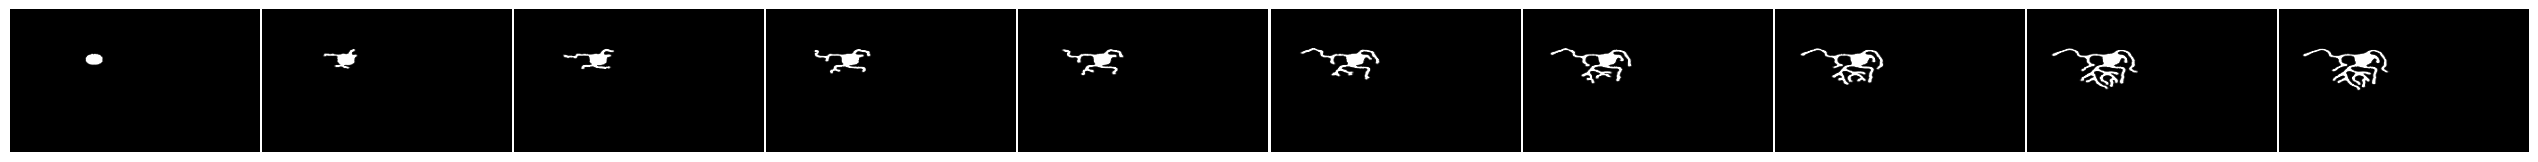

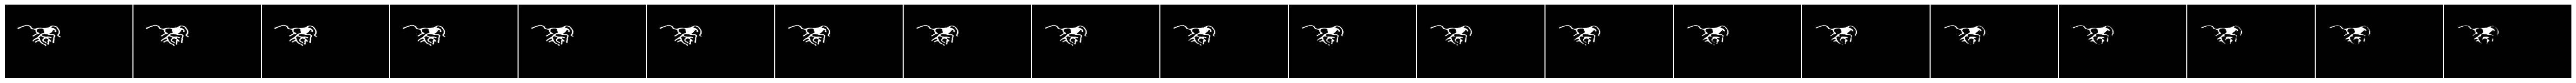

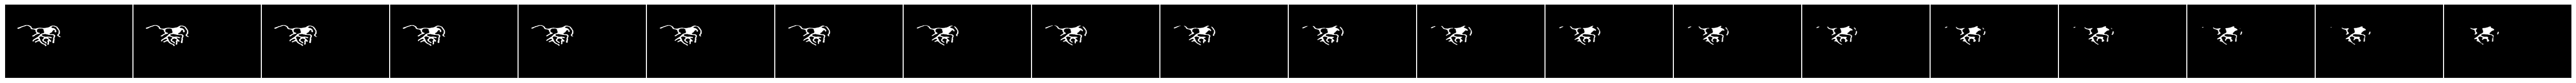

In [13]:
# Generate a random index for the example
example_idx = np.random.randint(0, len(inputs))

# Show the frames for the input, prediction, and ground truth
show_video_line(inputs[example_idx], ncols=10, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)
show_video_line(preds[example_idx], ncols=20, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)
show_video_line(trues[example_idx], ncols=20, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

Average Error: 2.7923%
Max error index: 159


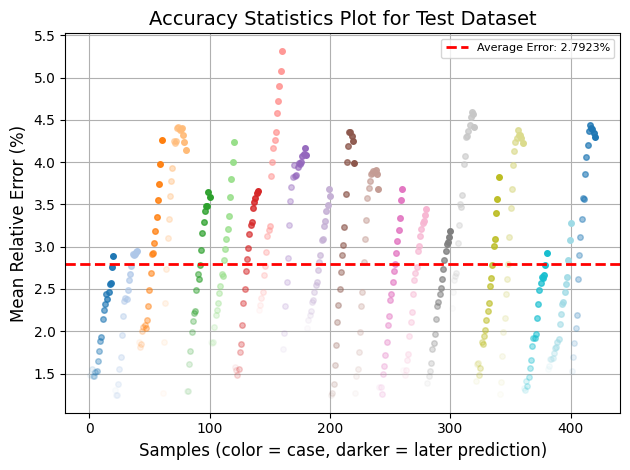

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def ComputeTestError(prediction, target):
    num_pixels = np.prod(target.shape)
    squared_error = np.sum((target - prediction) ** 2) / num_pixels
    phi_gt_max = np.max(target)
    phi_gt_min = np.min(target)
    mre = np.sqrt(squared_error) / (phi_gt_max - phi_gt_min) * 100
    
    return mre

def TestErrorPlot(pred, true, figsize=(10, 6), dpi=200, out_path="./statistics_testdata.png"):
    """Plot the test error for the given predictions and true data, save as PNG."""
    error_List = []
    testID_List = []
    count = 1

    # Get the number of cases and number of comparisons from pred.shape
    num_cases = pred.shape[0]
    num_comparisons = pred.shape[1]

    # Loop through each case in the prediction and true arrays
    for i in range(num_cases):
        # Use a qualitative colormap for contrasting colors (e.g., tab20 colormap)
        color = plt.cm.tab20(i % 20)  # Ensures up to 20 distinct colors
        
        # For each case, we calculate the error for all comparisons (inferred from pred.shape[1])
        for j in range(num_comparisons):
            # Compute test error for each comparison
            tmp_error = ComputeTestError(pred[i, j], true[i, j])
            error_List.append(tmp_error)
            testID_List.append(count)

            # Vary transparency (alpha) based on comparison position in the case
            alpha_value = (j + 1) / num_comparisons  # Later points are more transparent
            plt.plot(count, tmp_error, 'o', color=color, markersize=4, alpha=alpha_value)
            count += 1

    # Convert lists to numpy arrays
    testID_List = np.asarray(testID_List)
    error_List = np.asarray(error_List)
    avg_error = np.average(error_List)
    
    # Plot the average error line across all cases
    plt.axhline(avg_error, color='red', linestyle='--', linewidth=2, label=f'Average Error: {avg_error:.4f}%')

    # Add labels and title
    plt.xlabel('Samples (color = case, darker = later prediction)', fontsize=12)
    plt.ylabel('Mean Relative Error (%)', fontsize=12)
    plt.title('Accuracy Statistics Plot for Test Dataset', fontsize=14)

    # Add gridlines for better readability
    plt.grid(True)

    # Add a legend for the average error
    plt.legend(loc='upper right', fontsize=8)  # Smaller legend font size
    
    # Save the figure with the specified size and resolution
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, format='png')

    # Display the average error in the terminal
    print(f'Average Error: {avg_error:.4f}%')
    print(f'Max error index: {np.argmax(error_List)}')

# Call the TestErrorPlot function
TestErrorPlot(preds, trues, figsize=(20, 8), dpi=300, out_path="./test_error_plot.png")


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imageio

def show_video_gif_multiple_withError(prev, true, pred, vmax=1.0, vmin=0.0, cmap='jet', norm=None, out_path=None, use_rgb=False):
    """Generate gif with a video sequence and plot absolute error along with mean relative error using provided MRE formula."""
    
    def swap_axes(x):
        if len(x.shape) > 3:
            return x.swapaxes(1, 2).swapaxes(2, 3)
        else:
            return x

    prev, true, pred = map(swap_axes, [prev, true, pred])
    prev_frames = prev.shape[0]
    frames = prev_frames + true.shape[0]
    images = []
    
    for i in range(frames):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))  # Larger figsize for higher resolution
        for t, ax in enumerate(axes):
            if t == 0:
                plt.text(0.3, 1.05, 'Ground Truth', fontsize=15, color='green', transform=ax.transAxes)
                if i < prev_frames:
                    frame = prev[i]
                else:
                    frame = true[i - prev_frames]
                im = ax.imshow(frame, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, aspect=10)
                cbar.ax.tick_params(labelsize=8)
                cbar.set_label('Pixel Value', fontsize=10)
                
            elif t == 1:
                plt.text(0.2, 1.05, 'Predicted Frames', fontsize=15, color='red', transform=ax.transAxes)
                if i < prev_frames:
                    frame = prev[i]
                else:
                    frame = pred[i - prev_frames]
                im = ax.imshow(frame, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, aspect=10)
                cbar.ax.tick_params(labelsize=8)
                cbar.set_label('Pixel Value', fontsize=10)
                
            elif t == 2:
                plt.text(0.2, 1.05, 'Absolute Error', fontsize=15, color='blue', transform=ax.transAxes)
                if i < prev_frames:
                    # Plot prev - prev (which should result in all zeros)
                    abs_error = np.zeros_like(prev[i])
                    mre = 0.0  # No error, as we are comparing the same frames
                else:
                    # Plot absolute error for the remaining frames
                    abs_error = np.abs(true[i - prev_frames] - pred[i - prev_frames])
                    
                    # Calculate MRE using the provided formula
                    phi_gt = true[i - prev_frames]
                    phi_pred = pred[i - prev_frames]
                    num_pixels = np.prod(phi_gt.shape)
                    squared_error = np.sum((phi_gt - phi_pred) ** 2) / num_pixels
                    phi_gt_max = np.max(phi_gt)
                    phi_gt_min = np.min(phi_gt)
                    mre = np.sqrt(squared_error) / (phi_gt_max - phi_gt_min) * 100

                im = ax.imshow(abs_error, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, aspect=10)
                cbar.ax.tick_params(labelsize=8)
                cbar.set_label('Absolute Error', fontsize=10)
                
                # Use ax.text() to manually place MRE below the third subplot
                ax.text(0.5, -0.1, f'Mean Relative Error: {mre:.4f}%', 
                        fontsize=12, color='blue', ha='center', transform=ax.transAxes)

            ax.axis('off')
        
        # Save the frame to the temporary image and append to images list for GIF creation
        plt.savefig(f'./tmp_frame_{i}.png', bbox_inches='tight', format='png', dpi=300)  # Higher DPI
        images.append(imageio.imread(f'./tmp_frame_{i}.png'))
        plt.close()

    # Remove temporary files after GIF creation
    if out_path is not None:
        if not out_path.endswith('gif'):
            out_path = out_path + '.gif'
        
        # Create GIF using the frames and set it to loop infinitely (loop=0)
        imageio.mimsave(out_path, images, duration=0.1, loop=0)  # loop=0 for infinite looping GIF

    # Optionally, clean up the temporary files after GIF creation
    for i in range(frames):
        os.remove(f'./tmp_frame_{i}.png')


In [16]:
# # Import the function for generating GIFs
# from openstl.utils import show_video_gif_multiple

for i in range(len(inputs)):
    example_idx = i

    # Modify the output filename to include the random index
    output_gif_filename = f'./prediction_gif/example_{example_idx}.gif'
    # show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], out_path=output_gif_filename)
    show_video_gif_multiple_withError(inputs[example_idx], trues[example_idx], preds[example_idx], out_path=output_gif_filename)

    print(f"GIF saved as {output_gif_filename}")

GIF saved as ./prediction_gif/example_0.gif
GIF saved as ./prediction_gif/example_1.gif
GIF saved as ./prediction_gif/example_2.gif
GIF saved as ./prediction_gif/example_3.gif
GIF saved as ./prediction_gif/example_4.gif
GIF saved as ./prediction_gif/example_5.gif
GIF saved as ./prediction_gif/example_6.gif
GIF saved as ./prediction_gif/example_7.gif
GIF saved as ./prediction_gif/example_8.gif
GIF saved as ./prediction_gif/example_9.gif
GIF saved as ./prediction_gif/example_10.gif
GIF saved as ./prediction_gif/example_11.gif
GIF saved as ./prediction_gif/example_12.gif
GIF saved as ./prediction_gif/example_13.gif
GIF saved as ./prediction_gif/example_14.gif
GIF saved as ./prediction_gif/example_15.gif
GIF saved as ./prediction_gif/example_16.gif
GIF saved as ./prediction_gif/example_17.gif
GIF saved as ./prediction_gif/example_18.gif
GIF saved as ./prediction_gif/example_19.gif
GIF saved as ./prediction_gif/example_20.gif


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

def show_video_gif_multiple_withError(prev, true, pred, vmax=1.0, vmin=0.0, cmap='jet', norm=None, out_path=None, use_rgb=False):
    """Generate a 3-row figure with ground truth, prediction, and error, handling initial 10 frames in prev and subsequent 20 frames in true/pred."""
    
    def swap_axes(x):
        if len(x.shape) > 3:
            return x.swapaxes(1, 2).swapaxes(2, 3)
        else:
            return x

    prev, true, pred = map(swap_axes, [prev, true, pred])
    prev_frames = prev.shape[0]  # prev contains the first 10 frames
    true_frames = true.shape[0]  # true contains the next 20 frames
    pred_frames = pred.shape[0]  # pred contains the next 20 frames

    # Sample ground truth: 3 frames from 0-9 in prev, 5 frames from 10-29 in true
    sampled_gt_indices_prev = [0, 5, 9]  # Frames 0, 5, 9 from prev
    sampled_gt_indices_true = list(np.linspace(10, 29, 5, dtype=int))  # 5 frames from true (10-29)
    
    # Sample prediction: 5 frames from pred (10-29)
    sampled_pred_indices = list(np.linspace(0, pred_frames - 1, 5, dtype=int))  # Sampling within pred frames (0 to 19 in pred)

    # Ensure output directory exists
    if not os.path.exists('prediction_gif'):
        os.makedirs('prediction_gif')
    
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(24, 7))  # 3 rows, 8 columns
    fig.subplots_adjust(hspace=0.1, wspace=0.05)  # Reduce the white space between subplots

    for row, ax_row in enumerate(axes):
        if row == 0:  # Ground Truth Row
            for i, ax in enumerate(ax_row):
                if i < 3:
                    # Plot frames from 0-9 from prev (first 3)
                    frame = prev[sampled_gt_indices_prev[i]]
                    ax.imshow(frame, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                    ax.set_title(f'Input {sampled_gt_indices_prev[i]}', fontsize=10)  # Smaller font size
                else:
                    # Plot 5 sampled frames from 10-29 from true
                    frame = true[sampled_gt_indices_true[i-3] - 10]  # Offset by -10 to match true frames starting from 10
                    ax.imshow(frame, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                    ax.set_title(f'Ground Truth {sampled_gt_indices_true[i-3]}', fontsize=10)  # Smaller font size
                
                # Remove x and y axis numbers
                ax.set_xticks([])  # Remove x-axis numbers
                ax.set_yticks([])  # Remove y-axis numbers
        
        elif row == 1:  # Prediction Row
            for i, ax in enumerate(ax_row):
                if i < 3:
                    # Leave first 3 subplots empty for predictions (since pred starts at frame 10)
                    ax.axis('off')
                else:
                    # Plot 5 sampled frames from pred (10-29 in true corresponds to 0-19 in pred)
                    frame = pred[sampled_pred_indices[i-3]]
                    ax.imshow(frame, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                    ax.set_title(f'Prediction {sampled_pred_indices[i-3] + 10}', fontsize=8)  # Smaller font size

                # Remove x and y axis numbers
                ax.set_xticks([])  # Remove x-axis numbers
                ax.set_yticks([])  # Remove y-axis numbers
        
        elif row == 2:  # Error Row
            for i, ax in enumerate(ax_row):
                if i < 3:
                    # Leave first 3 subplots empty for errors (since no prediction exists for these frames)
                    ax.axis('off')
                else:
                    # Plot absolute error for sampled frames from 10-29 in true and pred (0 to 19 in pred)
                    gt_frame = true[sampled_gt_indices_true[i-3] - 10]  # Offset by -10 to match true frames starting from 10
                    pred_frame = pred[sampled_pred_indices[i-3]]
                    abs_error = np.abs(gt_frame - pred_frame)
                    ax.imshow(abs_error, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
                    ax.set_title(f'Absolute Error {sampled_pred_indices[i-3] + 10}', fontsize=10)  # Smaller font size

                    # Calculate MRE (Mean Relative Error)
                    num_pixels = np.prod(gt_frame.shape)
                    squared_error = np.sum((gt_frame - pred_frame) ** 2) / num_pixels
                    phi_gt_max = np.max(gt_frame)
                    phi_gt_min = np.min(gt_frame)
                    mre = np.sqrt(squared_error) / (phi_gt_max - phi_gt_min) * 100

                    # Display MRE below the subplot
                    ax.text(0.5, -0.1, f'MRE: {mre:.4f}%', fontsize=10, color='blue', ha='center', transform=ax.transAxes)  # Smaller text size

                # Remove x and y axis numbers
                ax.set_xticks([])  # Remove x-axis numbers
                ax.set_yticks([])  # Remove y-axis numbers

    # Save the figure for each case
    if out_path is not None:
        output_path = os.path.join('prediction_gif', out_path + '.png')
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Figure saved as {output_path}")
    
    plt.close()

# Example of how to call the modified function:
for i in range(len(inputs)):
    example_idx = i

    # Modify the output filename to include the example index
    output_png_filename = f'example_{example_idx}'
    show_video_gif_multiple_withError(inputs[example_idx], trues[example_idx], preds[example_idx], out_path=output_png_filename)

    print(f"Figure saved as {output_png_filename}.png in prediction_gif folder")


Figure saved as prediction_gif/example_0.png
Figure saved as example_0.png in prediction_gif folder
Figure saved as prediction_gif/example_1.png
Figure saved as example_1.png in prediction_gif folder
Figure saved as prediction_gif/example_2.png
Figure saved as example_2.png in prediction_gif folder
Figure saved as prediction_gif/example_3.png
Figure saved as example_3.png in prediction_gif folder
Figure saved as prediction_gif/example_4.png
Figure saved as example_4.png in prediction_gif folder
Figure saved as prediction_gif/example_5.png
Figure saved as example_5.png in prediction_gif folder
Figure saved as prediction_gif/example_6.png
Figure saved as example_6.png in prediction_gif folder
Figure saved as prediction_gif/example_7.png
Figure saved as example_7.png in prediction_gif folder
Figure saved as prediction_gif/example_8.png
Figure saved as example_8.png in prediction_gif folder
Figure saved as prediction_gif/example_9.png
Figure saved as example_9.png in prediction_gif folder
